# Visualizing all attention heads

# Imports

In [ ]:
!pip install timm einops matplotlib pillow --quiet

import torch, timm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from google.colab import drive

# Sample Image

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


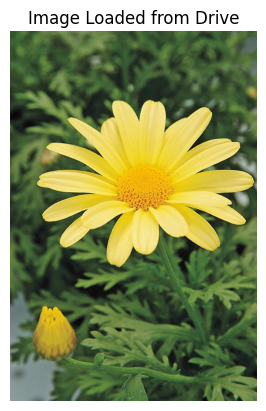

In [ ]:
image_path = "/content/sample_data/daisy.jpg"

img = Image.open(image_path).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.title("Image Loaded from Drive")
plt.show()

# Model

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = timm.create_model('vit_small_patch16_224', pretrained=True)
model.eval().to(DEVICE)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

# Attention Visualization Hook

In [ ]:
transform = timm.data.create_transform(input_size=224)
x = transform(img).unsqueeze(0).to(DEVICE)   # [1,3,224,224]

In [ ]:
for blk in model.blocks:
    blk.attn._forward_hooks.clear()

attn_maps = []

In [ ]:
def get_attention_map_hook(module, input, output):
    B, N, C = input[0].shape
    qkv = module.qkv(input[0])  # linear projection: [B, N, 3*C]
    qkv = qkv.reshape(B, N, 3, module.num_heads, C // module.num_heads)
    qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, B, heads, tokens, dim]
    q, k = qkv[0], qkv[1]
    attn = (q @ k.transpose(-2, -1)) * (1.0 / (k.shape[-1] ** 0.5))
    attn = attn.softmax(dim=-1)
    attn_maps.append(attn.detach().cpu())

In [ ]:
model.blocks[-1].attn.register_forward_hook(get_attention_map_hook)


In [ ]:
with torch.no_grad():
    _ = model(x)

In [ ]:
attn = attn_maps[-1][0]  # [heads, tokens, tokens]
num_heads = attn.shape[0]

# CLS token attention to patches
cls_attn = attn[:, 0, 1:]
num_patches = int(cls_attn.shape[1] ** 0.5)
cls_attn = cls_attn.reshape(num_heads, num_patches, num_patches)

In [ ]:
# Upsample to image size
cls_attn_upsampled = F.interpolate(
    cls_attn.unsqueeze(1),
    size=(224, 224),
    mode='bilinear',
    align_corners=False
).squeeze(1)

In [ ]:

cls_attn_norm = []
for i in range(cls_attn_upsampled.shape[0]):
    a = cls_attn_upsampled[i]
    a = (a - a.min()) / (a.max() - a.min() + 1e-8)
    cls_attn_norm.append(a)
cls_attn_upsampled = torch.stack(cls_attn_norm)


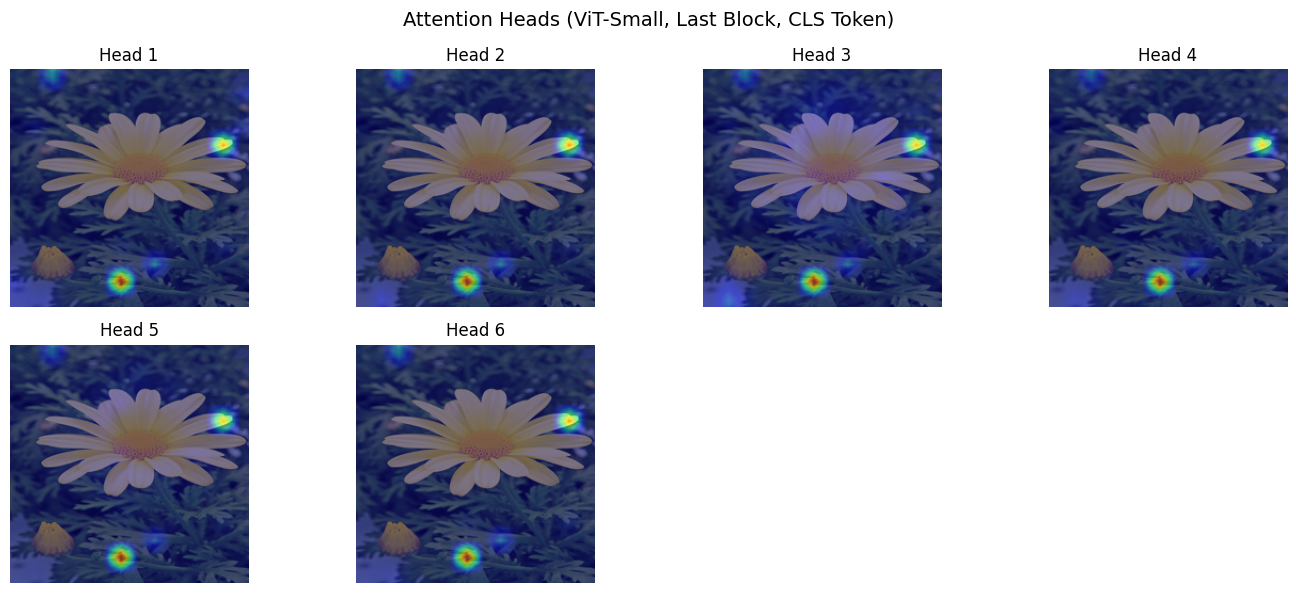

In [ ]:
img_np = np.array(img.resize((224,224))) / 255.0
cols = 4
rows = int(np.ceil(num_heads / cols))

plt.figure(figsize=(14, rows*3))
for i in range(num_heads):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img_np)
    plt.imshow(cls_attn_upsampled[i], cmap='jet', alpha=0.5)
    plt.title(f'Head {i+1}')
    plt.axis('off')

plt.suptitle("Attention Heads (ViT-Small, Last Block, CLS Token)", fontsize=14)
plt.tight_layout()
plt.show()

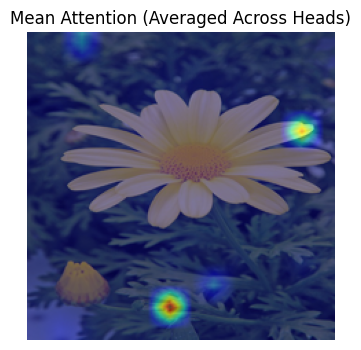

In [ ]:
mean_attn = cls_attn_upsampled.mean(0)
plt.figure(figsize=(6,4))
plt.imshow(img_np)
plt.imshow(mean_attn, cmap='jet', alpha=0.5)
plt.title("Mean Attention (Averaged Across Heads)")
plt.axis('off')
plt.show()

# Attention Maps from early vs.middle.vs last transformer blocks

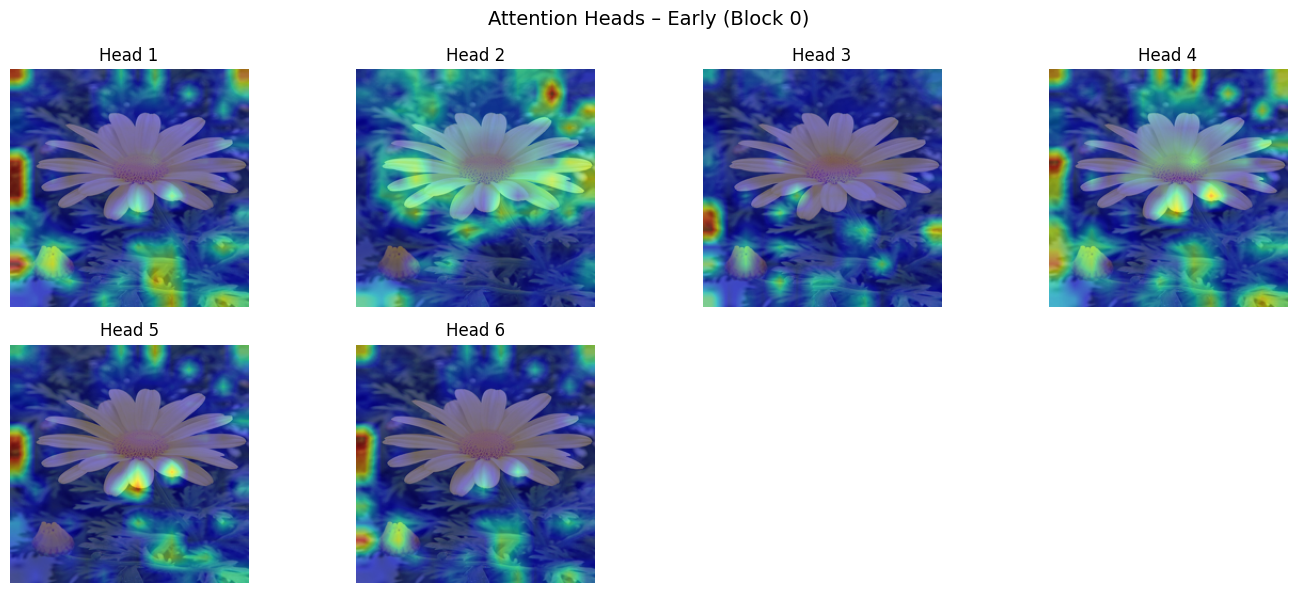

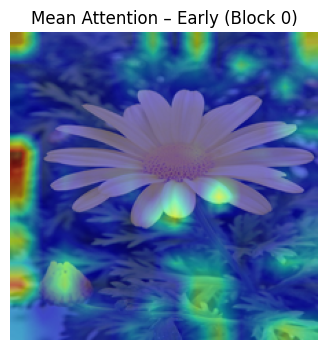

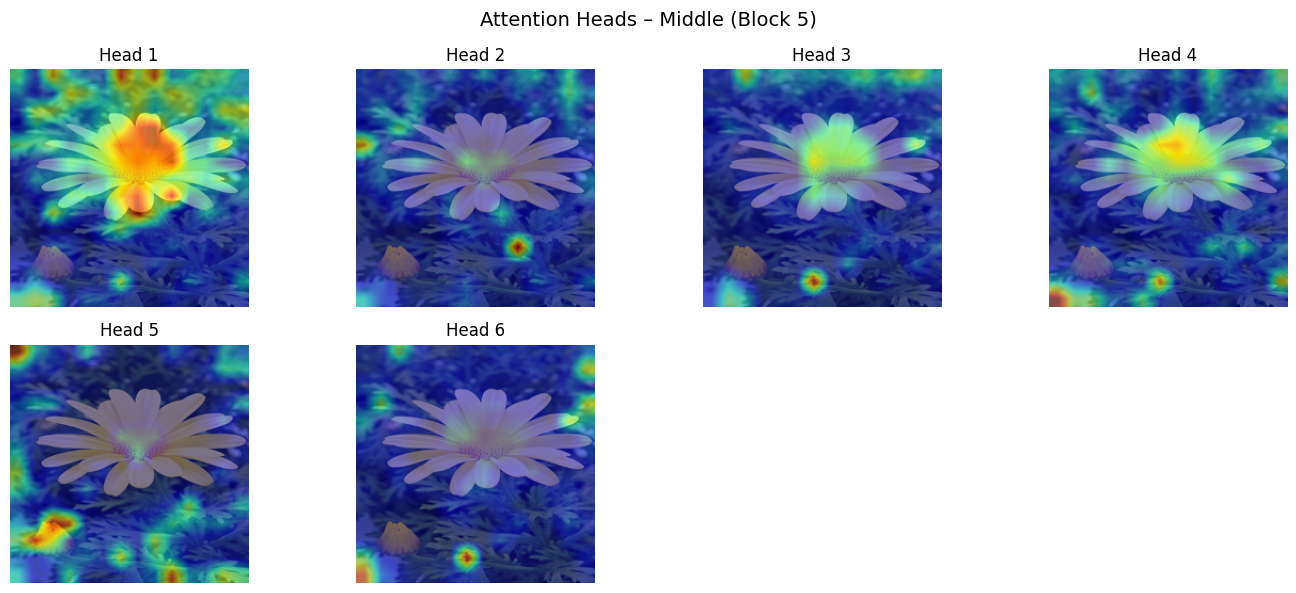

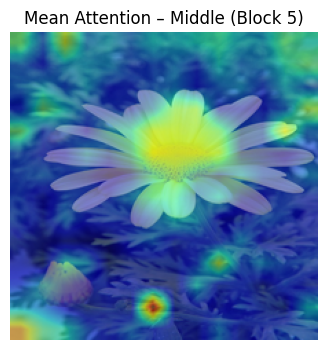

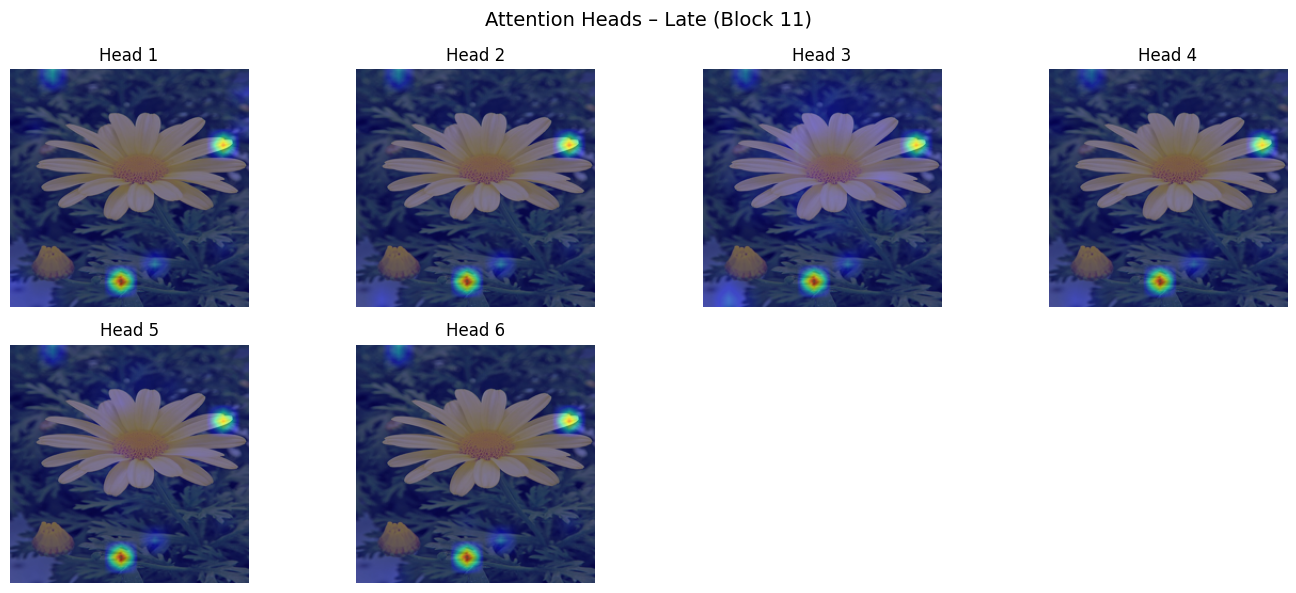

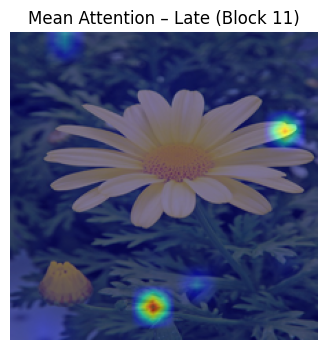

In [ ]:


# Helper function to capture attention maps

def extract_attention_from_block(model, block_index, x):
    attn_maps = []
    def hook_fn(module, input, output):
        B, N, C = input[0].shape
        qkv = module.qkv(input[0])
        qkv = qkv.reshape(B, N, 3, module.num_heads, C // module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, B, heads, tokens, dim]
        q, k = qkv[0], qkv[1]
        attn = (q @ k.transpose(-2, -1)) * (1.0 / (k.shape[-1] ** 0.5))
        attn = attn.softmax(dim=-1)
        attn_maps.append(attn.detach().cpu())

    # clear old hooks and register new
    for blk in model.blocks:
        blk.attn._forward_hooks.clear()
    handle = model.blocks[block_index].attn.register_forward_hook(hook_fn)

    with torch.no_grad():
        _ = model(x)
    handle.remove()
    return attn_maps[-1][0]  # [heads, tokens, tokens]

# Choose blocks to visualize

blocks_to_show = {
    "Early (Block 0)": 0,
    "Middle (Block 5)": 5,
    "Late (Block 11)": len(model.blocks) - 1
}

# Extract attention maps for each stage

attn_stages = {}
for label, idx in blocks_to_show.items():
    attn = extract_attention_from_block(model, idx, x)
    attn_stages[label] = attn

# Process and visualize each stage

img_np = np.array(img.resize((224,224))) / 255.0
for label, attn in attn_stages.items():
    num_heads = attn.shape[0]
    cls_attn = attn[:, 0, 1:]
    num_patches = int(cls_attn.shape[1] ** 0.5)
    cls_attn = cls_attn.reshape(num_heads, num_patches, num_patches)

    # Upsample
    cls_attn_upsampled = F.interpolate(
        cls_attn.unsqueeze(1),
        size=(224, 224),
        mode='bilinear',
        align_corners=False
    ).squeeze(1)

    # Normalize
    norm_maps = []
    for i in range(num_heads):
        a = cls_attn_upsampled[i]
        a = (a - a.min()) / (a.max() - a.min() + 1e-8)
        norm_maps.append(a)
    cls_attn_upsampled = torch.stack(norm_maps)

    # Plot grid for this block
    cols = 4
    rows = int(np.ceil(num_heads / cols))
    plt.figure(figsize=(14, rows*3))
    for i in range(num_heads):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img_np)
        plt.imshow(cls_attn_upsampled[i], cmap='jet', alpha=0.5)
        plt.title(f'Head {i+1}')
        plt.axis('off')
    plt.suptitle(f"Attention Heads – {label}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Mean attention overlay
    mean_attn = cls_attn_upsampled.mean(0)
    plt.figure(figsize=(6,4))
    plt.imshow(img_np)
    plt.imshow(mean_attn, cmap='jet', alpha=0.5)
    plt.title(f"Mean Attention – {label}")
    plt.axis('off')
    plt.show()
